# Imports

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Importing Data

In [2]:
path = os.path.join(os.getcwd(), "data")
data = pd.read_csv(os.path.join(path, "processed_hotel_bookings.csv"), index_col=0)

# Processing Data

In [3]:
# separating data into features (X) and outcomes (y)
X = data.loc[:, data.columns != 'is_canceled']
y = data['is_canceled']

# splitting data into training (70%) and testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [4]:
# final training data
X_train

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
53763,136,2016,6,27,29,0,3,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
21865,13,2016,3,11,6,2,5,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
35812,100,2017,4,17,29,2,1,2,0.0,0,...,0,0,0,1,0,0,0,0,0,1
37270,42,2017,6,23,5,2,5,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
46448,11,2016,1,1,2,2,1,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13708,50,2017,8,35,27,2,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
16383,45,2015,8,34,21,2,5,2,0.0,0,...,0,0,0,1,0,0,0,0,0,1
42448,61,2015,9,36,5,2,2,2,0.0,0,...,0,0,0,1,0,0,0,0,0,1
86088,7,2016,3,13,24,0,3,2,1.0,0,...,0,0,0,1,0,0,0,0,1,0


# Random Forest

In [5]:
n_estimators = [200, 1000, 2000]
max_depth = [10, 50, 100]
max_depth.append(None)
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

## Test Run

In [6]:
# # Getting confusion matrix: rows are actual values, columns are predicted
# test = RandomForestRegressor()
# test.fit(X_train, y_train)
# y_pred_test = np.round(test.predict(X_test))
# cm = confusion_matrix(y_test, y_pred_test)
# cm

## Model Training

In [7]:
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 50, 100, None],
                         'n_estimators': [200, 1000, 2000]})

## Model Analysis

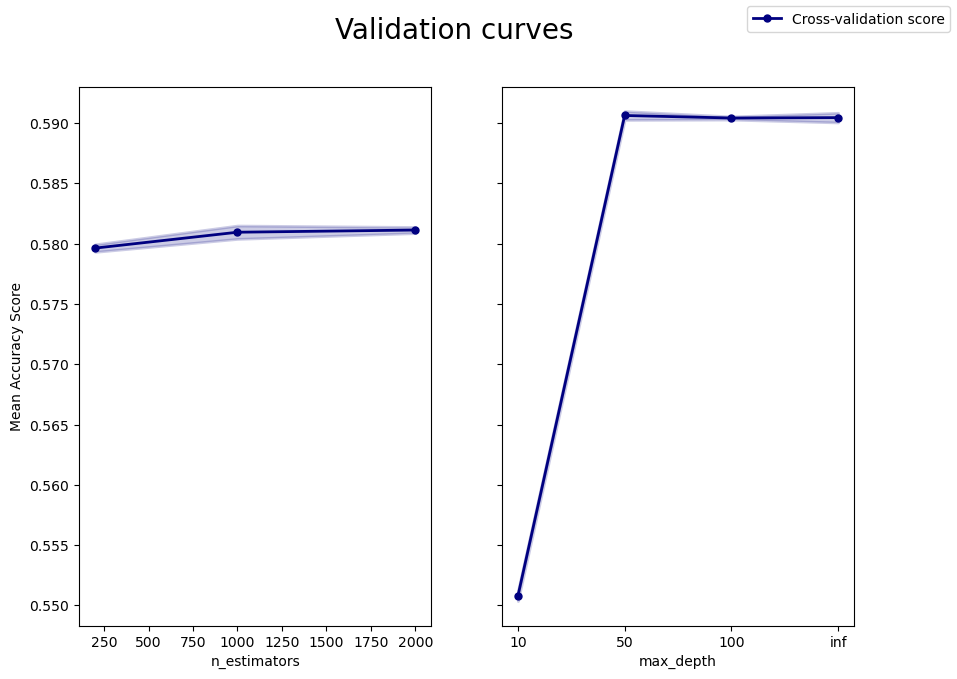

In [8]:
# graphing parameters and associated validation error
df = pd.DataFrame(rf_grid.cv_results_)
results = ['mean_test_score',
           'std_test_score']
df['param_max_depth'] = df['param_max_depth'].replace({None: 'inf'})
param_grid['max_depth'] = ['10', '50', '100', 'inf']

fig, axes = plt.subplots(1, len(param_grid), 
                         figsize = (5*len(param_grid), 7),
                         sharey='row')
axes[0].set_ylabel("Mean Accuracy Score", fontsize=10)


for idx, (param_name, param_range) in enumerate(param_grid.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_test_score': 'mean',
              'std_test_score': 'std'})
    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=10)
    lw = 2
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw, marker ='o', ms=5)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=20)
fig.legend(handles, labels, fontsize=10)
 
plt.show();

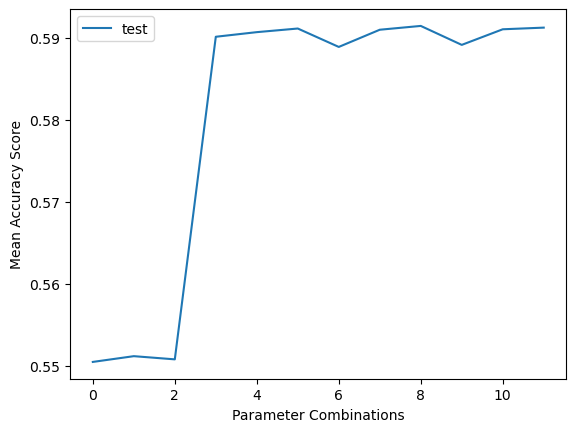

In [9]:
test_scores = rf_grid.cv_results_['mean_test_score'] 

plt.plot(test_scores, label='test')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean Accuracy Score')
plt.legend(loc='best')
plt.show()

In [10]:
# printing best params and validation score
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'max_depth': 100, 'n_estimators': 2000}
0.5914345956745692


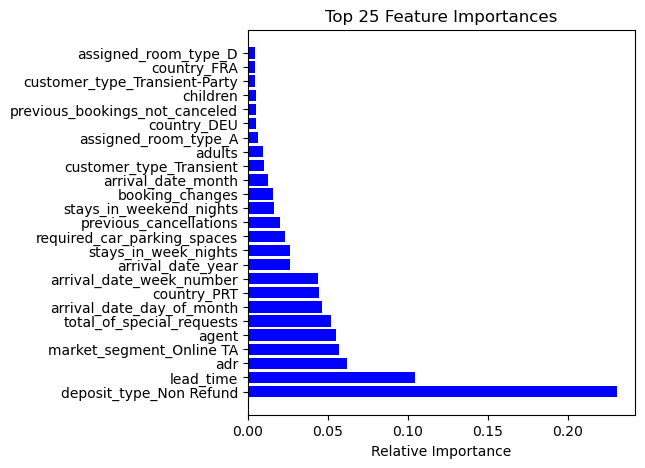

In [11]:
top = pd.DataFrame({'Feature': X.columns, 
                    'Importance': rf_grid.best_estimator_.feature_importances_
                   }).sort_values(by=['Importance'], ascending=False).head(25)

plt.figure(figsize=(5,5))
plt.title('Top 25 Feature Importances')
plt.barh(range(len(top)), top['Importance'], color='b', align='center')
plt.yticks(range(len(top)), top['Feature'])
plt.xlabel('Relative Importance')

plt.show()

## Model Testing

In [12]:
# testing best rf model
# getting confusion matrix: rows are actual values, columns are predicted
y_pred_probs = rf_grid.predict(X_test)
y_pred = np.round(y_pred_probs)
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm)

,0,1
0,4123,406
1,516,2088


In [15]:
# not canceling is positive
# canceling is negative
accuracy = (cm[0][0] + cm [1][1]) / np.sum(cm)
precision = (cm[0][0]) / np.sum(cm[0, :])
recall = (cm[0][0]) / np.sum(cm[:, 0])
f1 = 2 * (precision * recall) / (precision + recall)
fp = (cm[1][0]) / np.sum(cm[:, 0])
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("False Negative:", fp)
print("F1:", f1)

Accuracy: 0.8707416234403477
Precision: 0.910355486862442
Recall: 0.8887691312782927
False Negative: 0.11123086872170726
F1: 0.8994328097731239


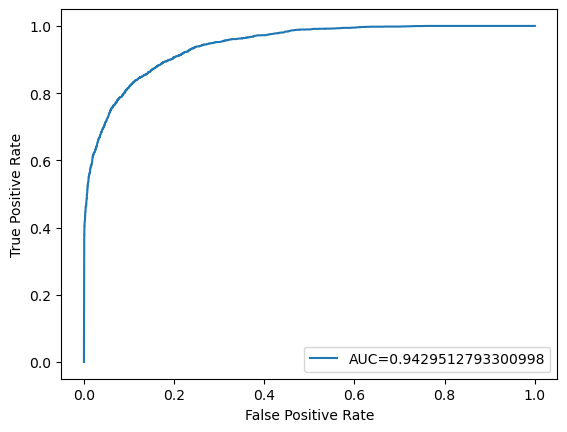

In [14]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_probs)
auc = roc_auc_score(y_test, y_pred_probs)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
